# Streaming and interacting with NWB data from DANDI

First, let's import a few classes. Please install (or upgrade) these packages using `pip` or your favorite Python package manager. For example:
```
pip install -U dandi pynwb remfile matplotlib "numpy<2" pynapple seaborn
```

In [1]:
from dandi.dandiapi import DandiAPIClient
import remfile
import h5py
import matplotlib.pyplot as plt
import numpy as np
import pynwb

The data used in this tutorial were used in this publication: [Sargolini, et al. "Conjunctive representation of position, direction, and velocity in entorhinal cortex." Science 312.5774 (2006): 758-762](https://www.science.org/doi/10.1126/science.1125572). The data can be found on the DANDI Archive in [Dandiset 000582](https://dandiarchive.org/dandiset/000582).

In [2]:
dandiset_id = "000582"
filepath = "sub-10073/sub-10073_ses-17010302_behavior+ecephys.nwb"
with DandiAPIClient() as client:
    asset = client.get_dandiset(dandiset_id, 'draft').get_asset_by_path(filepath)
    s3_url = asset.get_content_url(follow_redirects=1, strip_query=True)

In [3]:
s3_url

'https://dandiarchive.s3.amazonaws.com/blobs/26a/22c/26a22c31-09bc-43a4-9187-edc7394ed12c'

Let's stream the NWB file using `remfile` and open the file using `PyNWB`.

In [4]:
# Create a disk cache to store downloaded data (optional)
cache_dirname = 'remfile_cache'
disk_cache = remfile.DiskCache(cache_dirname)

In [5]:
# open the file using the S3 URL
rem_file = remfile.File(s3_url, disk_cache=disk_cache)
h5py_file = h5py.File(rem_file, "r")
io = pynwb.NWBHDF5IO(file=h5py_file)
nwbfile = io.read()

/Users/rly/miniconda3/envs/test/lib/python3.12/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


You can print the `NWBFile` object in a Jupyter notebook to get a simplified, interactive representation of the contents of the NWB file.

In [6]:
nwbfile

root pynwb.file.NWBFile at 0x4675004384
Fields:
  acquisition: {
    ElectricalSeries <class 'pynwb.ecephys.ElectricalSeries'>
  }
  devices: {
    EEG <class 'pynwb.device.Device'>
  }
  electrode_groups: {
    ElectrodeGroup <class 'pynwb.ecephys.ElectrodeGroup'>
  }
  electrodes: electrodes <class 'hdmf.common.table.DynamicTable'>
  experiment_description: The sample includes conjunctive cells and head direction cells from layers III and V of medial entorhinal cortex and have been published in Sargolini et al. (Science, 2006).
  experimenter: ['Sargolini, Francesca']
  file_create_date: [datetime.datetime(2023, 9, 16, 15, 50, 9, 775622, tzinfo=tzoffset(None, 7200))]
  identifier: 294b7de1-a624-44d8-b1a1-28028dd2cf0c
  institution: Centre for the Biology of Memory, Norwegian University of Science and Technology
  keywords: <StrDataset for HDF5 dataset "keywords": shape (3,), type "|O">
  lab: Moser
  processing: {
    behavior <class 'pynwb.base.ProcessingModule'>,
    ecephys <class 'pynwb.base.ProcessingModule'>
  }
  related_publications: ['https://doi.org/10.1126/science.1125572']
  session_description: This session includes spike and position times for recorded cells from a Long Evans rat that was running in a 1 x 1 meter enclosure. The cells were recorded in the dorsocaudal 25% portion of the medial entorhinal cortex (MEC).Position is given for two LEDs to enable calculation of head direction.
  session_id: 17010302
  session_start_time: 1900-01-01 00:00:00+01:00
  subject: subject pynwb.file.Subject at 0x4675000208
Fields:
  age: P3M/P5M
  age__reference: birth
  description: A Long Evans rat.
  sex: M
  species: Rattus norvegicus
  subject_id: 10073
  weight: 0.35/0.45

  timestamps_reference_time: 1900-01-01 00:00:00+01:00
  units: units <class 'pynwb.misc.Units'>

Access `nwbfile.subject` to get information about the subject used in this experiment, including their age, sex, species, and ID. Age uses the ISO 8601 standard for time durations - `P3M` corresponds to 3 months old, and `P3M/P5M` means the subject was between 3-5 months old.

In [7]:
nwbfile.subject

subject pynwb.file.Subject at 0x4675000208
Fields:
  age: P3M/P5M
  age__reference: birth
  description: A Long Evans rat.
  sex: M
  species: Rattus norvegicus
  subject_id: 10073
  weight: 0.35/0.45

Now let's access the position of the animal, which is stored in a `SpatialSeries` object at this particular path within the NWB file.

In [8]:
position = nwbfile.processing["behavior"]["Position"]["SpatialSeriesLED1"]
position

Data type,float64
Shape,"(30000, 2)"
Array size,468.75 KiB
Chunk shape,"(1875, 1)"
Compression,gzip
Compression opts,4
Compression ratio,1.0575039821634329
Data type,float64
Shape,"(30000,)"
Array size,234.38 KiB
Chunk shape,"(1875,)"


## Lazy loading of datasets
Data arrays are read passively from the NWB file.
Accessing the ``data`` attribute of the `SpatialSeries` object
does not read the data values, but presents an `h5py.Dataset` object that can be indexed to read data.
You can use the ``[:]`` operator to read the entire data array into memory.

In [9]:
position.data

<HDF5 dataset "data": shape (30000, 2), type "<f8">

In [10]:
pos_data = position.data[:]
pos_data

array([[-0.4427946 , 17.10393108],
       [-0.4427946 , 17.10393108],
       [ 1.26778258, 16.85956291],
       ...,
       [ 2.00088708,  6.84046804],
       [ 2.00088708,  6.84046804],
       [ 0.77904624,  4.64115453]])

## Slicing datasets
Especially with very large datasets, it is often preferable to read only a portion of the data. To do this, index or slice into the ``data`` attribute just like if you were indexing or slicing a numpy array.

Let's get the X coordinates of the subject for all timestamps and get the timestamps.

In [11]:
x = position.data[:,0]
x

array([-0.4427946 , -0.4427946 ,  1.26778258, ...,  2.00088708,
        2.00088708,  0.77904624])

In [12]:
ts = position.timestamps[:]
ts

array([0.0000e+00, 2.0000e-02, 4.0000e-02, ..., 5.9994e+02, 5.9996e+02,
       5.9998e+02])

Now let's use those values to plot the X position of the subject over time. All times in NWB are stored in seconds relative to the session start time.

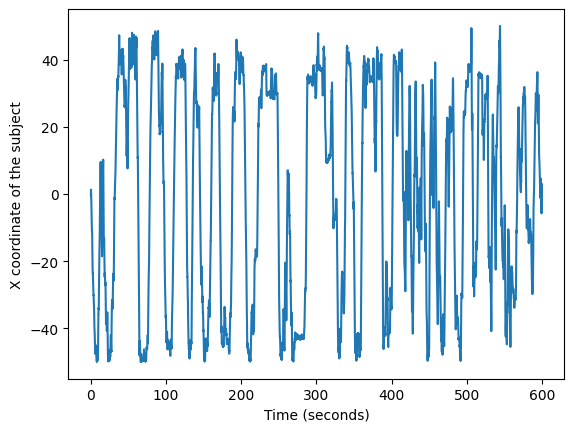

In [13]:
plt.plot(ts, x)
plt.xlabel("Time (seconds)")
plt.ylabel("X coordinate of the subject");

We can also slice in the time dimension. Let's plot the (x, y) position of the subject for the first 100 time points.

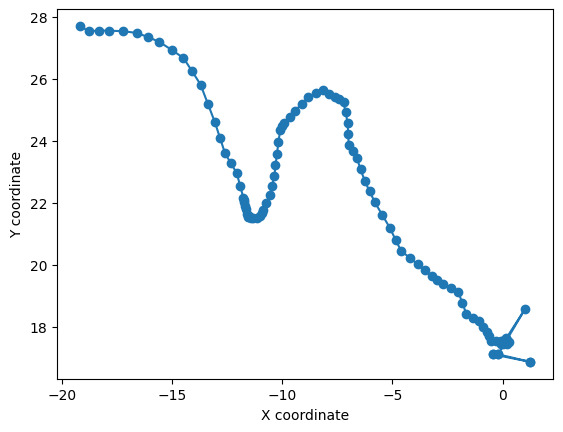

In [14]:
time_indices = slice(0, 100)
plt.plot(position.data[time_indices,0], position.data[time_indices,1], "-o")
plt.xlabel("X coordinate")
plt.ylabel("Y coordinate");

## Access single unit data

Data and metadata about sorted single units are stored in a `Units` object. It stores metadata about each single unit in a tabular form, where each row represents a unit with spike times and additional metadata.

In [15]:
nwbfile.units

,unit_name,spike_times,histology,hemisphere,depth
id,,,,,
0,t1c1,"[0.7903958333333333, 0.794, 0.8111666666666667, 0.8313541666666666, 0.9217708333333333, 1.0205208333333333, 1.3573020833333334, 1.6583229166666666, 1.6768645833333333, 2.7457708333333333, 4.008697916666667, 4.01678125, 4.402270833333334, 4.522583333333333, 4.527708333333333, 5.598760416666667, 5.61415625, 5.617927083333333, 5.68934375, 5.701510416666666, 5.714885416666666, 5.71740625, 5.723197916666667, 5.806802083333333, 5.8149375, 5.8207708333333334, 6.1641875, 6.201979166666667, 6.2260625, 6.2363125, 6.3546875, 6.363916666666666, 6.480145833333333, 6.48803125, 6.899927083333333, 6.992489583333334, 6.995885416666667, 7.033135416666667, 7.098052083333333, 7.10146875, 7.105677083333333, 7.245541666666667, 11.069739583333334, 11.499979166666666, 11.5111875, 11.522375, 11.6165, 11.702270833333333, 11.714625, 11.7245, 11.920979166666667, 11.983385416666666, 11.98634375, 11.995645833333333, 12.08903125, 12.105385416666667, 12.148697916666666, 12.157114583333334, 12.165864583333333, 13.123729166666667, 13.206645833333333, 13.224875, 13.232479166666666, 13.362927083333334, 13.40890625, 13.522697916666667, 13.530177083333333, 13.54115625, 13.623927083333333, 13.685302083333333, 13.738260416666666, 13.757302083333334, 13.812510416666667, 13.855427083333334, 13.971072916666667, 13.98659375, 13.992822916666666, 14.082979166666666, 14.162229166666666, 14.165541666666666, 14.394229166666667, 14.397375, 14.488708333333333, 14.492708333333333, 14.500604166666667, 14.547833333333333, 14.563979166666666, 14.5875, 14.590729166666666, 14.59375, 14.601708333333333, 14.608729166666667, 14.620083333333334, 14.647083333333333, 14.699260416666666, 14.70190625, 14.741635416666666, 14.801010416666667, 14.80403125, 14.88940625, ...]",MEC LII,,0.0024
1,t2c1,"[1.0451354166666667, 1.7003854166666668, 2.3154375, 11.046822916666667, 14.239729166666667, 14.822927083333333, 14.837010416666667, 19.281322916666667, 19.585395833333333, 19.603958333333335, 19.719083333333334, 19.722625, 19.819458333333333, 19.822979166666666, 19.8256875, 19.829520833333333, 28.67203125, 29.932614583333333, 30.8508125, 30.951416666666667, 31.050583333333332, 31.106822916666665, 31.410760416666665, 36.44560416666667, 46.90858333333333, 47.34158333333333, 47.397375, 47.4190625, 47.47598958333333, 48.156, 59.66520833333333, 59.66970833333333, 59.78719791666666, 60.00934375, 60.12197916666667, 60.12890625, 60.458333333333336, 60.8745625, 61.55807291666667, 62.76680208333333, 62.94321875, 63.27045833333333, 63.4875, 64.47296875, 67.56085416666667, 67.57622916666666, 67.72179166666666, 67.72525, 67.80897916666666, 67.814625, 67.8276875, 67.91458333333334, 67.94144791666666, 67.95988541666667, 68.02155208333333, 68.13059375, 68.20140625, 68.33521875, 68.40710416666667, 68.57409375, 68.58878125, 68.681375, 68.70475, 68.75991666666667, 68.832625, 68.9400625, 68.94379166666667, 71.02867708333333, 71.25821875, 71.41845833333333, 72.28534375, 78.7965, 79.7308125, 79.76083333333334, 79.84297916666667, 79.91891666666666, 79.97095833333333, 80.08979166666667, 83.240875, 88.275625, 91.66017708333334, 91.67665625, 92.069125, 92.10191666666667, 92.56378125, 92.56932291666666, 92.57228125, 92.58971875, 92.59544791666667, 92.67121875, 92.67442708333333, 92.81330208333334, 92.84265625, 93.16694791666667, 93.28475, 93.47997916666667, 93.49264583333333, 93.51422916666667, 93.51847916666667, 93.52220833333334, ...]",MEC LII,,0.0024
2,t2c3,"[0.18273958333333334, 0.5340729166666667, 0.5707291666666666, 0.7023333333333334, 0.7242604166666666, 0.7670520833333333, 0.88084375, 1.06084375, 1.1815, 1.2828333333333333, 1.2922916666666666, 1.4162291666666667, 1.5238333333333334, 1.5430416666666666, 1.5909479166666667, 1.6242291666666666, 1.6451041666666666, 1.7132604166666667, 3.0415729166666665, 5.295635416666666, 5.516947916666667, 6.2452604166666665, 6.336885416666667, 6.6401666666666666, 7.0116875, 7.089395833333334, 7.20128125, 8.1189375, 8.154

We can view the single unit data as a pandas `DataFrame`.

In [16]:
units_df = nwbfile.units.to_dataframe()
units_df

,unit_name,spike_times,histology,hemisphere,depth
id,,,,,
0,t1c1,"[0.7903958333333333, 0.794, 0.8111666666666667...",MEC LII,,0.0024
1,t2c1,"[1.0451354166666667, 1.7003854166666668, 2.315...",MEC LII,,0.0024
2,t2c3,"[0.18273958333333334, 0.5340729166666667, 0.57...",MEC LII,,0.0024
3,t3c1,"[1.0358229166666666, 1.04803125, 1.69642708333...",MEC LII,,0.0024
4,t3c2,"[2.43025, 2.4398333333333335, 3.17965625, 3.39...",MEC LII,,0.0024
5,t3c3,"[2.1157708333333334, 2.425427083333333, 3.3630...",MEC LII,,0.0024
6,t3c4,"[0.07945833333333334, 2.244947916666667, 3.173...",MEC LII,,0.0024
7,t4c1,"[2.4301666666666666, 2.439770833333333, 3.1795...",MEC LII,,0.0024


To access the spike times of the first single unit, index this pandas dataframe with the column name, “spike_times”, and the row index, 0. All times in NWB are stored in seconds relative to the session start time.

In [17]:
units_df["spike_times"][0]

array([  0.79039583,   0.794     ,   0.81116667, ..., 595.28703125,
       595.53125   , 599.68578125])

We can also inspect the columns of the `Units` table for useful metadata such as descriptions of the values of each column.

In [18]:
nwbfile.units["depth"].description

'Indicates the depth of the inserted electrodes in meters.'

# Using [Pynapple](https://pynapple-org.github.io/pynapple/) for data analysis

[Pynapple](https://pynapple-org.github.io/pynapple/) is a light-weight python library for neurophysiological data analysis that accepts NWB files as input. Seaborn is a popular plotting package.

Let's import `pynapple` and `seaborn`, set some seaborn plotting parameters, and load the streamed NWB file into Pynapple by creating a `nap.NWBFile` object using the `pynwb.NWBFile` object that we created earlier from `io.read()`.

In [19]:
import pynapple as nap
import seaborn as sns

custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", palette="colorblind", font_scale=1.5, rc=custom_params)

nwb = nap.NWBFile(nwbfile)

nwb

17010302
┍━━━━━━━━━━━━━━━━━━━━━┯━━━━━━━━━━┑
│ Keys                │ Type     │
┝━━━━━━━━━━━━━━━━━━━━━┿━━━━━━━━━━┥
│ units               │ TsGroup  │
│ ElectricalSeriesLFP │ Tsd      │
│ SpatialSeriesLED1   │ TsdFrame │
│ ElectricalSeries    │ Tsd      │
┕━━━━━━━━━━━━━━━━━━━━━┷━━━━━━━━━━┙

We can load the sorted units as a pynapple `TsGroup` for inspection.

In [20]:
units = nwb["units"]
units

  Index     rate  unit_name    histology    hemisphere      depth
-------  -------  -----------  -----------  ------------  -------
      0  2.93217  t1c1         MEC LII                     0.0024
      1  1.50193  t2c1         MEC LII                     0.0024
      2  2.57878  t2c3         MEC LII                     0.0024
      3  1.13186  t3c1         MEC LII                     0.0024
      4  1.29356  t3c2         MEC LII                     0.0024
      5  1.35857  t3c3         MEC LII                     0.0024
      6  2.8855   t3c4         MEC LII                     0.0024
      7  1.46525  t4c1         MEC LII                     0.0024

We can also load the position data, which is a pynapple `TsdFrame`.

In [21]:
position = nwb["SpatialSeriesLED1"]
position

Time (s)    x         y
----------  --------  --------
0.0         -0.44279  17.10393
0.02        -0.44279  17.10393
0.04        1.26778   16.85956
0.06        1.26778   16.85956
0.08        -0.19843  17.10393
0.1         -0.19843  17.10393
0.12        1.02341   18.57014
...         ...       ...
599.86      2.97836   4.39679
599.88      2.97836   4.39679
599.9       2.24526   4.88552
599.92      2.24526   4.88552
599.94      2.00089   6.84047
599.96      2.00089   6.84047
599.98      0.77905   4.64115
dtype: float64, shape: (30000, 2)

Next, let's compute the 2d tuning curves and plot them. 
(A warning is raised because the animal did not enter some position bins, which results in division by zero and NaN values in the tuning curve.)

/Users/rly/miniconda3/envs/test/lib/python3.12/site-packages/pynapple/process/tuning_curves.py:269: RuntimeWarning: invalid value encountered in divide
  count = count / occupancy


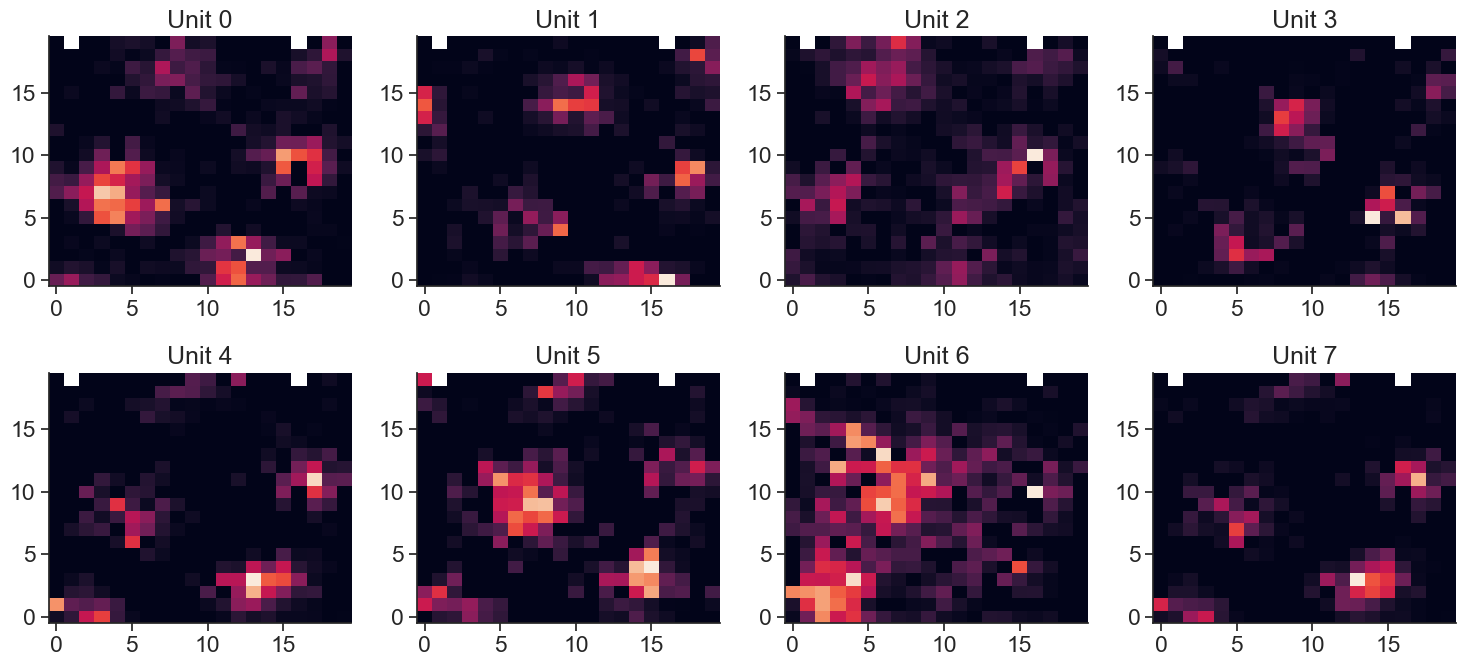

In [22]:
tc, binsxy = nap.compute_2d_tuning_curves(units, position, 20)

plt.figure(figsize=(15, 7))
for i in tc.keys():
    plt.subplot(2, 4, i + 1)
    plt.imshow(tc[i], origin="lower", aspect="auto")
    plt.title("Unit {}".format(i))
plt.tight_layout()
plt.show()

Finally, let's plot the spikes of unit 1, which has a nice grid. Let's use the function `value_from` to assign to each spike the closest position in time.

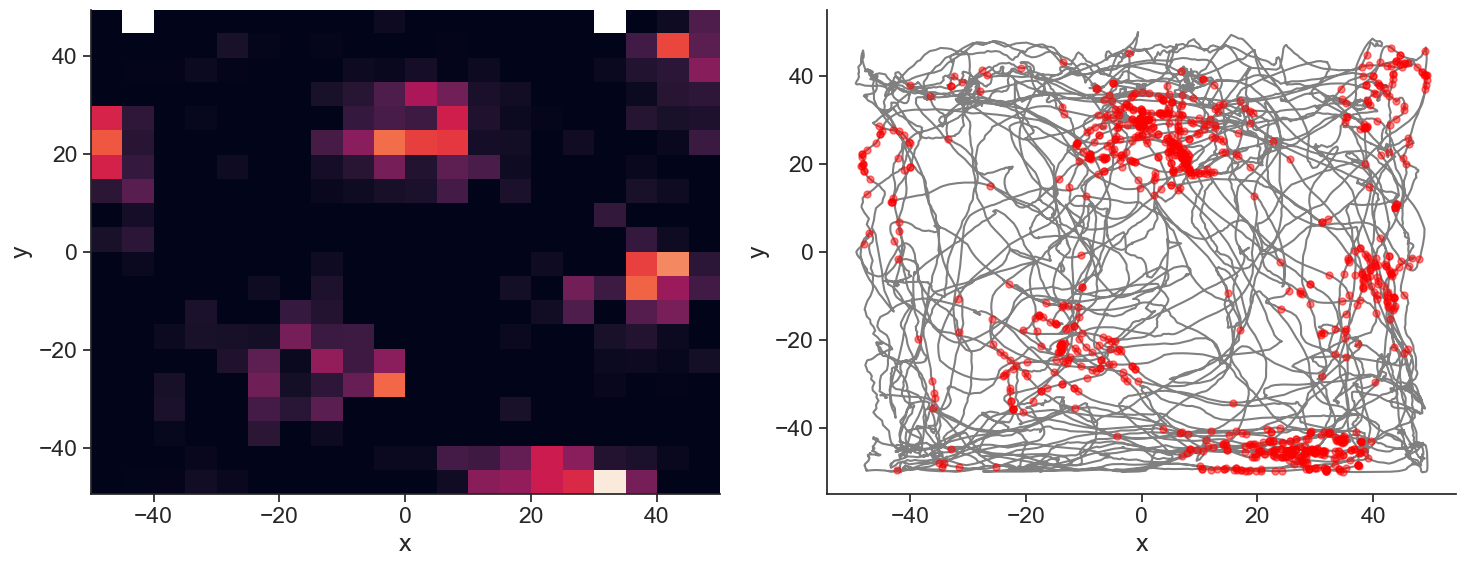

In [23]:
plt.figure(figsize=(15, 6))
plt.subplot(121)
extent = (
    np.min(position["x"]),
    np.max(position["x"]),
    np.min(position["y"]),
    np.max(position["y"]),
)
plt.imshow(tc[1], origin="lower", extent=extent, aspect="auto")
plt.xlabel("x")
plt.ylabel("y")

plt.subplot(122)
plt.plot(position["y"], position["x"], color="grey")
spk_pos = units[1].value_from(position)
plt.plot(spk_pos["y"], spk_pos["x"], "o", color="red", markersize=5, alpha=0.5)
plt.xlabel("x")
plt.ylabel("y")
plt.tight_layout()
plt.show()

It is good practice to close any open file and IO objects when you are done working with them so that they can be modified by other processes.

In [24]:
io.close()
h5py_file.close()
rem_file.close()